In [ ]:
!pip install ucimlrepo

In [ ]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from ucimlrepo import fetch_ucirepo

In [ ]:
data = fetch_ucirepo(id=891)

df = data['data']['features'].head(5000)
df['target'] = data.data.targets.head(5000)

df.head()

<ipython-input-75-ec5360ac9f09>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = data.data.targets.head(5000)


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,target
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


In [ ]:
def utils_recognize_type(df, col, max_cat=20):
    if (df[col].dtype == "O") | (df[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

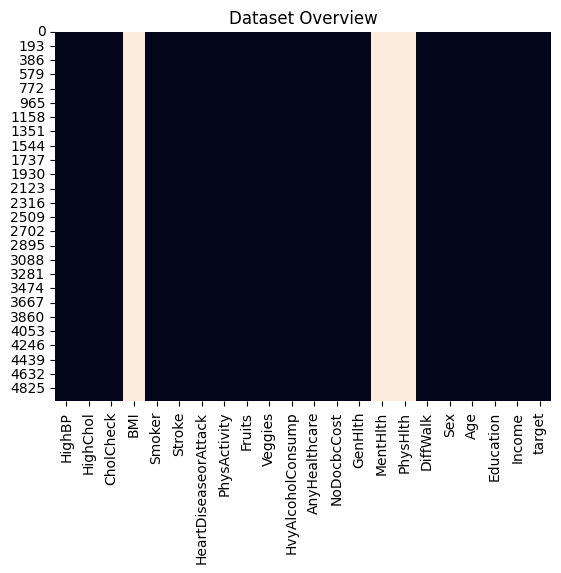

 Categerocial   Numeric   NaN 


In [ ]:
dic_cols = {col:utils_recognize_type(df, col, max_cat=20) for col in df.columns}
heatmap = df.isnull()

for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')

plt.show()

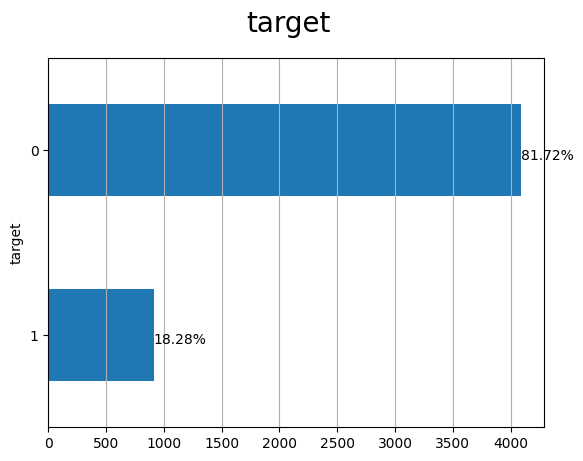

In [ ]:
y ="target"
ax = df[y].value_counts().sort_values().plot(kind="barh")

totals = []

for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20, str(round((i.get_width()/total)*100, 2))+'%', fontsize=10, color='black')

ax.grid(axis="x")
plt.suptitle(y, fontsize=20)

plt.show()

<ipython-input-14-bae191c539ca>:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])#зададим данные для графика
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


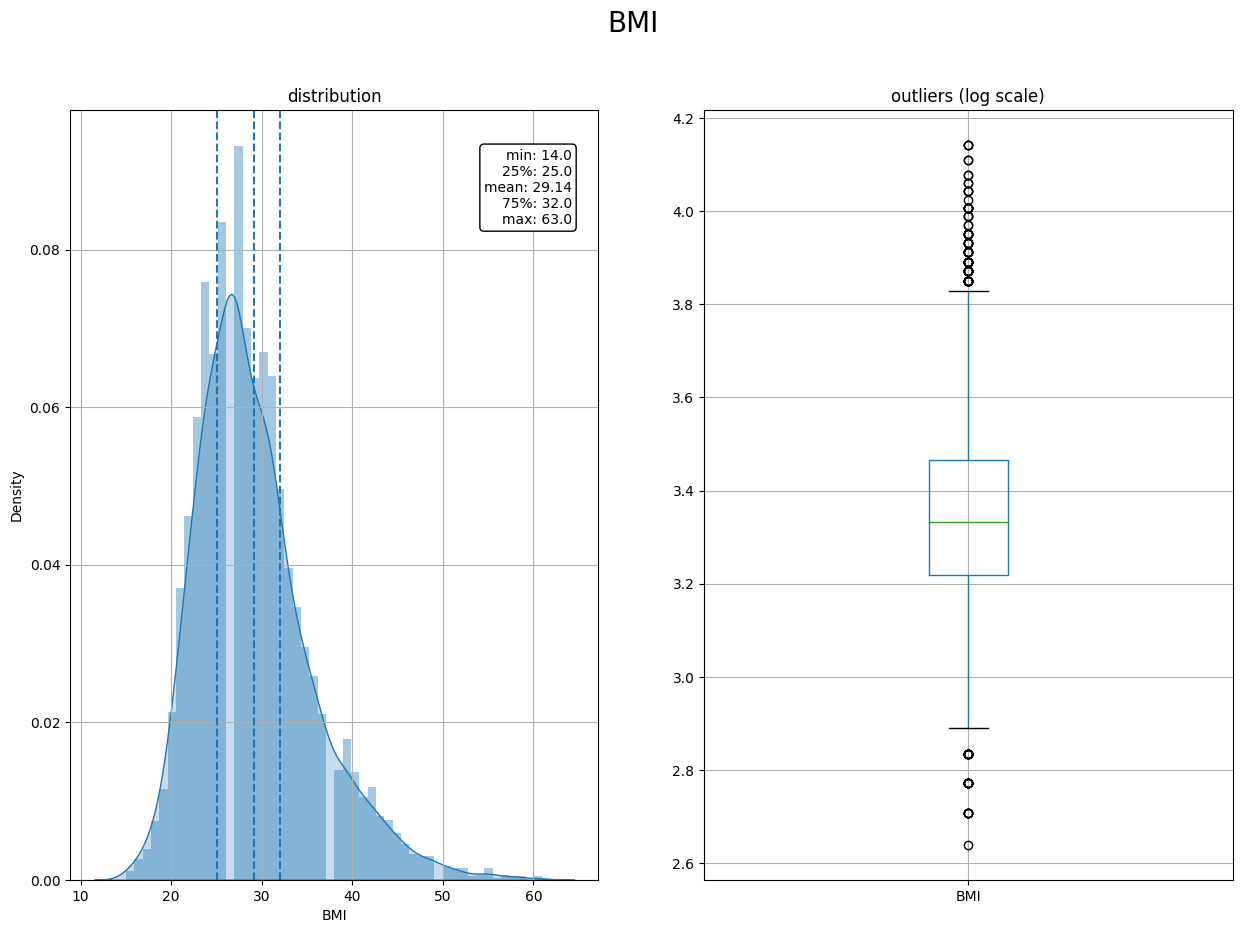

In [ ]:
x = "BMI"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False, figsize=(15, 10))
fig.suptitle(x, fontsize=20)
ax[0].title.set_text('distribution')

variable = df[x].fillna(df[x].mean())# замена отсутствующих значений в датафрейме на средние
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))#вычисляем q-й квантиль заданных данных вдоль указанной оси.
variable = variable[ (variable > breaks[0]) & (variable < breaks[10]) ]

sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = df[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(df[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])

plt.show()

In [ ]:
'''
А теперь обернем все, что было в предыдущей ячейке - в функцию для удобства повторного использования.
show_dist
'''

def show_dist(x, df):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 10))
    fig.suptitle(x, fontsize=20)
    ### distribution
    ax[0].title.set_text('distribution')
    variable = df[x].fillna(df[x].mean())
    breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
    variable = variable[(variable > breaks[0]) & (variable <
                                                  breaks[10])]
    sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
    des = df[x].describe()


    ax[0].axvline(des["25%"], ls='--')
    ax[0].axvline(des["mean"], ls='--')
    ax[0].axvline(des["75%"], ls='--')
    ax[0].grid(True)
    des = round(des, 2).apply(lambda x: str(x))
    box = '\n'.join(
        ("min: " + des["min"], "25%: " + des["25%"], "mean: " + des["mean"], "75%: " + des["75%"], "max: " + des["max"]))
    ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right",
               bbox=dict(boxstyle='round', facecolor='white', alpha=1))

    ax[1].title.set_text('outliers (log scale)')
    tmp_df = pd.DataFrame(df[x])
    tmp_df[x] = np.log(tmp_df[x])
    tmp_df.boxplot(column=x, ax=ax[1])

    plt.show()

<ipython-input-16-1becbe828810>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


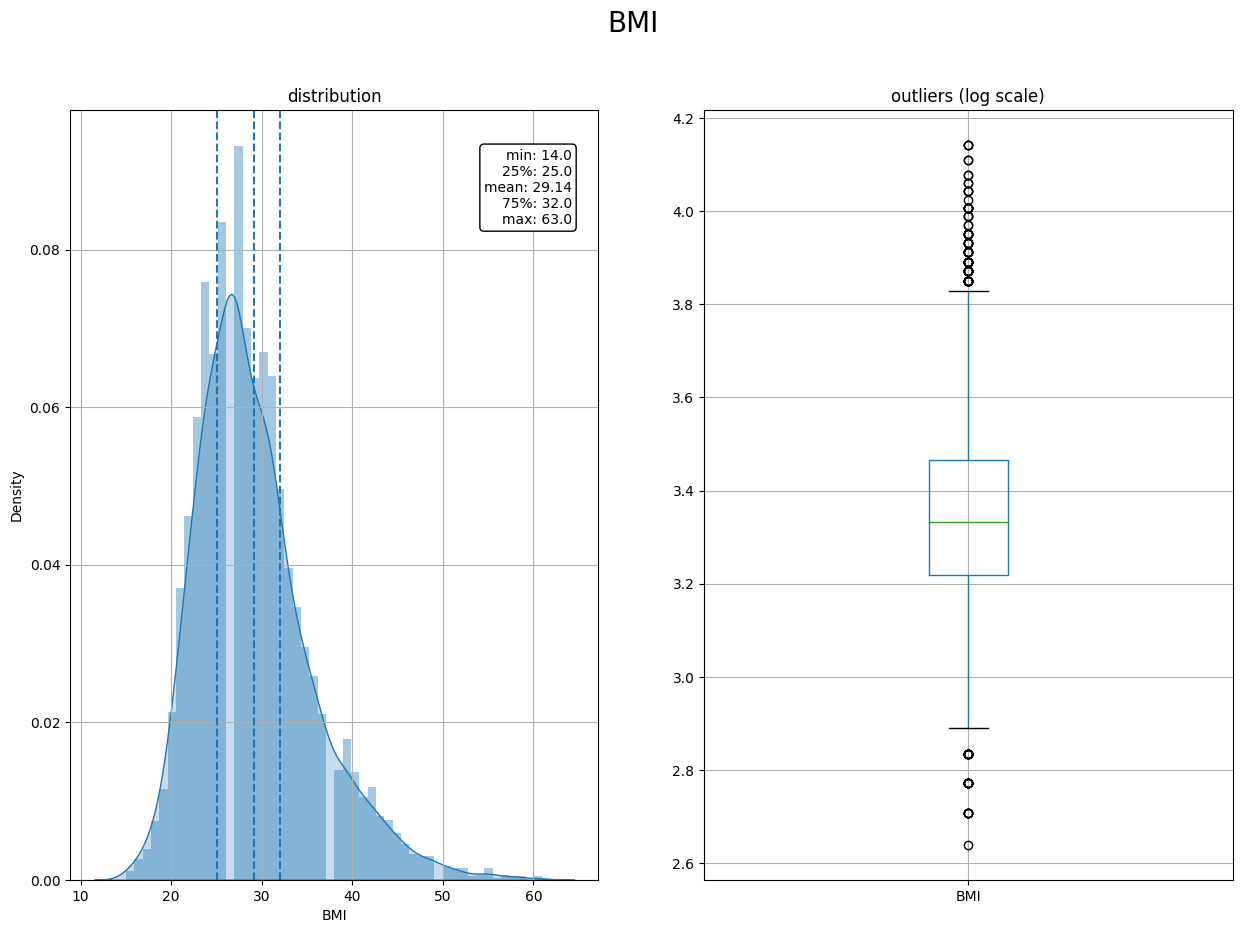

In [ ]:
show_dist('BMI', df)

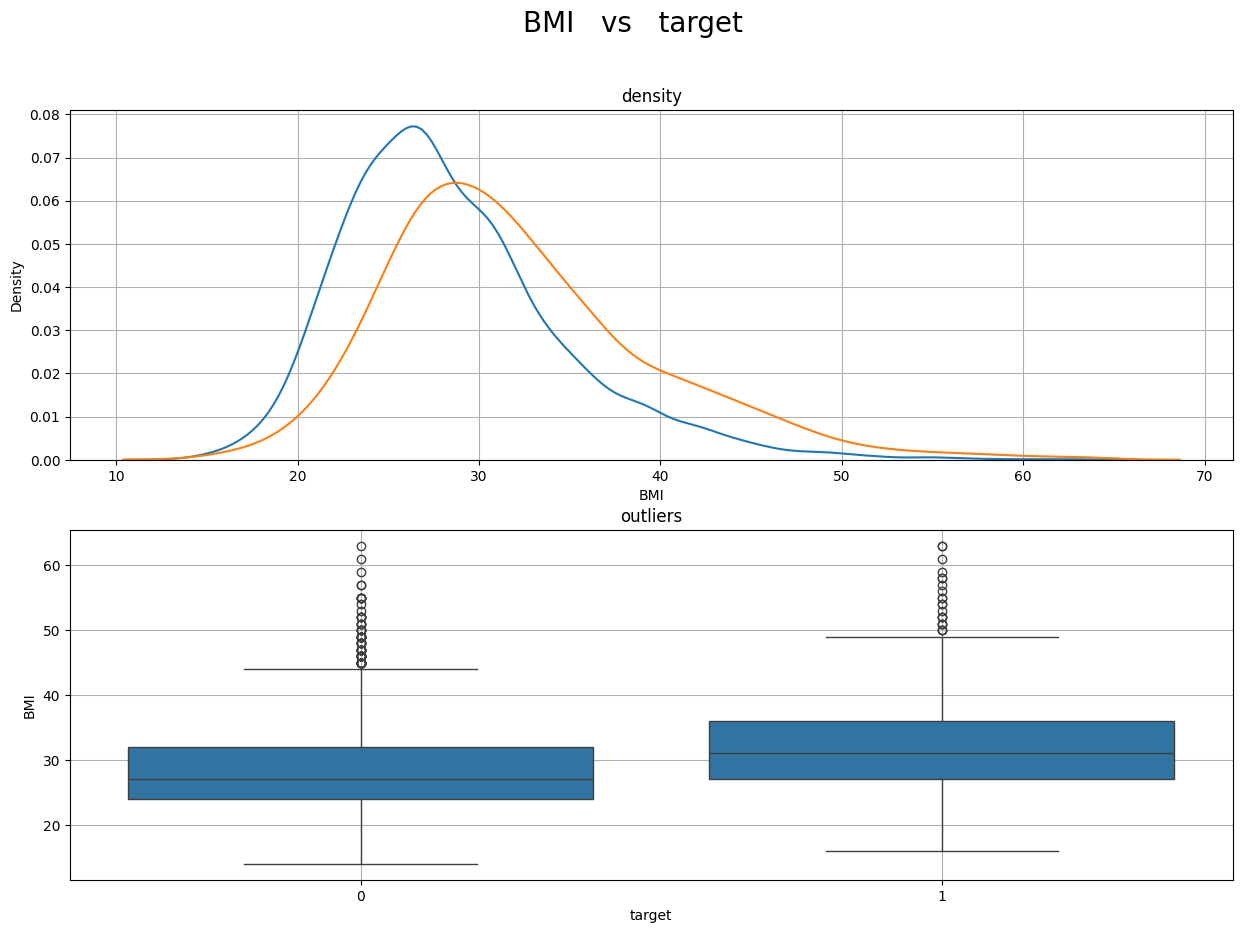

In [ ]:
'''
Для того, чтобы понять, обладает ли "BMI" предсказательной силой для предсказания "target", построим график плотности распределений и усиковую диаграмму BMI  для каждого уникального species.

'''

cat, num = "target", "BMI"
fig, ax = plt.subplots(nrows=2, ncols=1,  sharex=False, sharey=False, figsize=(15, 10))
fig.suptitle(x+"   vs   "+y, fontsize=20)

ax[0].title.set_text('density')
for i in df[cat].unique():
    sns.kdeplot(df[df[cat]==i][num],   label=i, ax=ax[0]) # Построим график плотности распределения в столбце num, при условии, что значение в столбце dtf[cat] совпадет с i
ax[0].grid(True)

ax[1].title.set_text('outliers')
sns.boxplot(x=cat, y=num, data=df, ax=ax[1]) # Нарисуем блочную диаграмму, чтобы показать распределения по категориям.
ax[1].grid(True)

plt.show()

In [ ]:
'''
    При разделении данных на обучающие и тестовые наборы вы должны следовать одному основному правилу:
        строки в обучающем наборе не должны также появляться в тестовом наборе.
        Это потому, что модель видит целевые значения во время обучения и использует их для понимания явления.
        Другими словами, модель уже знает правильный ответ для обучающих наблюдений (.
'''

df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

print("X_train shape:", df_train.drop("target",axis=1).shape, "| X_test shape:", df_test.drop("target",axis=1).shape)
print("y_train mean:", round(np.mean(df_train["target"]),2), "| y_test mean:", round(np.mean(df_test["target"]),2))
print(df_train.drop("target",axis=1).shape[1], "features:", df_train.drop("target",axis=1).columns.to_list())

X_train shape: (3500, 21) | X_test shape: (1500, 21)
y_train mean: 0.18 | y_test mean: 0.19
21 features: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


In [ ]:
df_train.shape

(3500, 22)

In [ ]:
# формируем вспомогательный датасет (где все нужные фичи(столбцы), и нет целевой переменной) и series с целевой переменной. Для трейна
train_x = df_train.drop('target', axis=1)
train_y = df_train['target']

In [ ]:
# формируем вспомогательный датасет (где все нужные фичи(столбцы), и нет целевой переменной) и series с целевой переменной. Для теста
test_x = df_test.drop('target', axis=1)
test_y = df_test['target']

In [ ]:
# нормируем значения
Y = 'target'

scaler = preprocessing.MinMaxScaler(feature_range=(0,1)) # приведем Числовые переменные (Numeric Variable) к диапазону от 0 до 1.
X = scaler.fit_transform(train_x) # преобразуем данные таким образом, что их распределение будет иметь среднее значение 0 и стандартное отклонение 1.

train_x_scaled = pd.DataFrame(X, columns=train_x.columns,index=train_x.index )
train_y_scaled = train_y

train_x_scaled.head() # выводим



,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
3684,1.0,0.0,1.0,0.208333,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.833333,1.0,0.714286
2068,1.0,1.0,1.0,0.354167,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.50,0.000000,0.066667,0.0,1.0,0.916667,0.8,0.857143
4911,1.0,0.0,1.0,0.270833,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.416667,1.0,1.000000
4251,1.0,0.0,1.0,0.500000,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.00,0.100000,0.666667,1.0,1.0,0.416667,0.8,0.142857
3568,1.0,1.0,1.0,0.270833,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.25,0.033333,0.033333,0.0,1.0,0.416667,1.0,1.000000


<ipython-input-16-1becbe828810>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


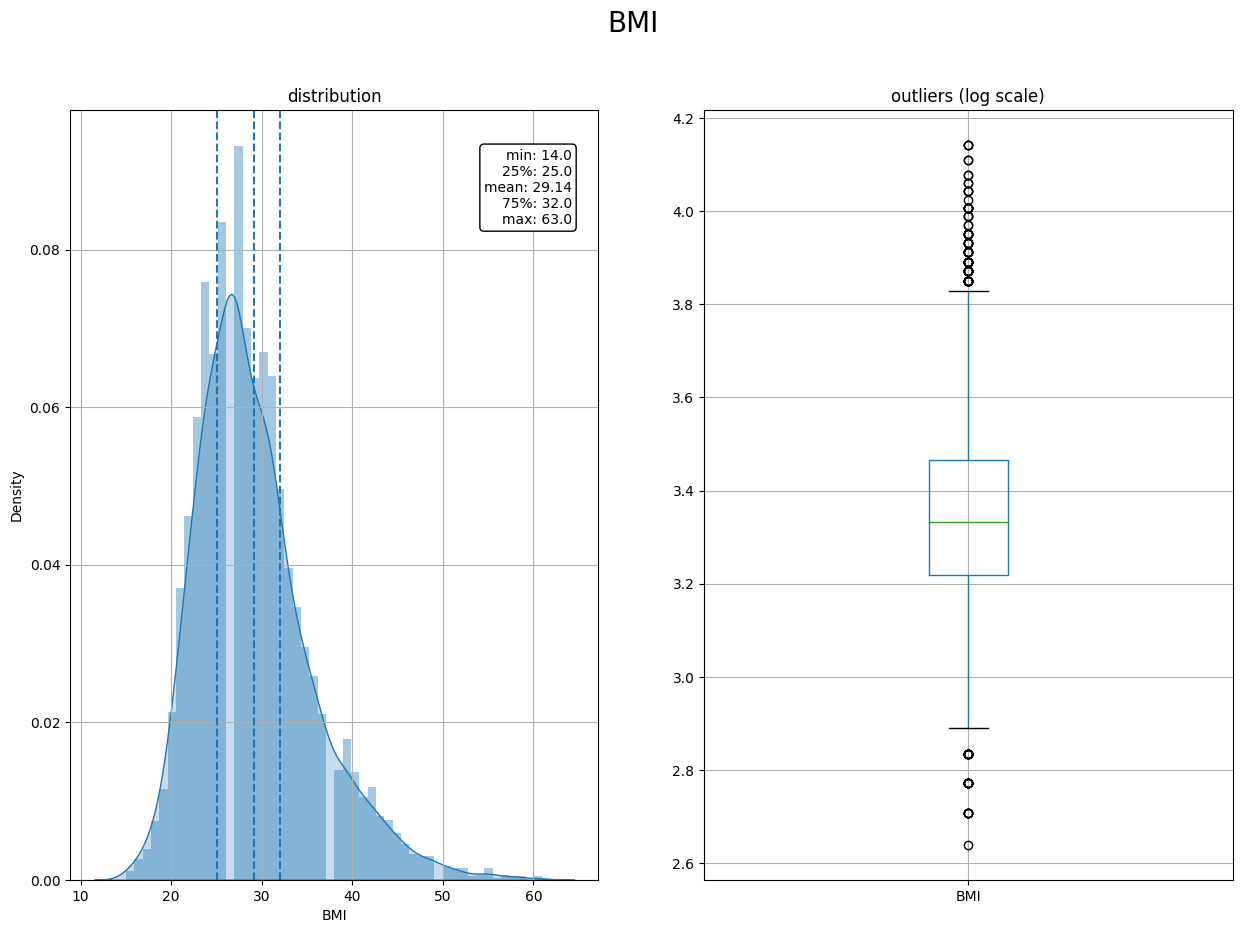

In [ ]:
show_dist('BMI', df) # используем ранее созданную нами функцию для отрисовки графиков

<ipython-input-16-1becbe828810>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True},
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


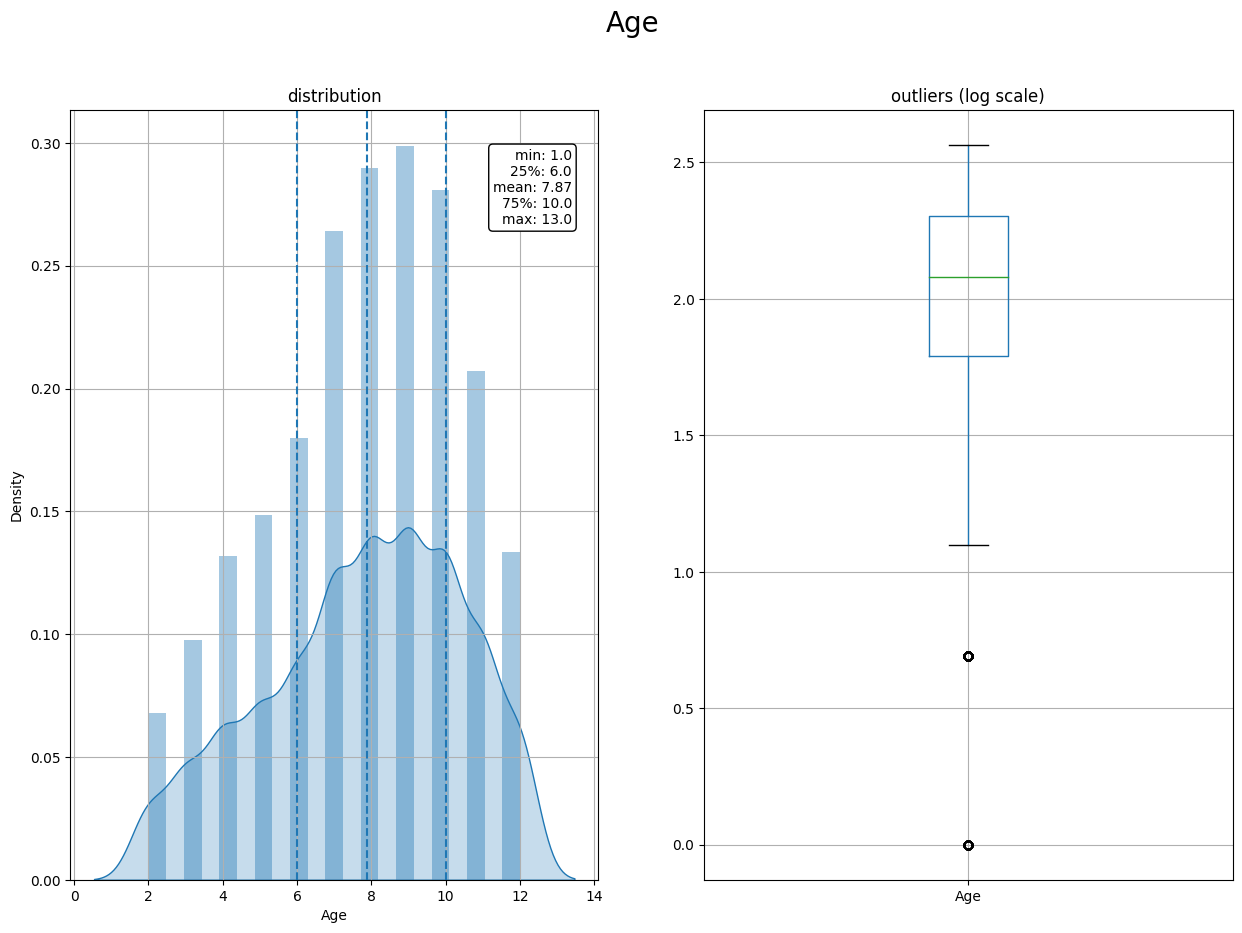

In [ ]:
show_dist('Age', df) # используем ранее созданную нами функцию для отрисовки графиков

In [ ]:
'''
Смотрим, что лежит в X, который результат нормировки train_x
'''
X

array([[1.        , 0.        , 1.        , ..., 0.83333333, 1.        ,
        0.71428571],
       [1.        , 1.        , 1.        , ..., 0.91666667, 0.8       ,
        0.85714286],
       [1.        , 0.        , 1.        , ..., 0.41666667, 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.75      , 0.6       ,
        0.28571429],
       [1.        , 1.        , 1.        , ..., 0.75      , 1.        ,
        0.42857143],
       [0.        , 0.        , 1.        , ..., 0.25      , 1.        ,
        0.57142857]])

In [ ]:
'''
смотрим какие индексы (по сути номера объектов в основном датасете) остались в трейне
'''
train_x.index


Index([3684, 2068, 4911, 4251, 3568, 1262, 3879,  306, 1069,  462,
       ...
       3605,  825, 1676, 3072,  500, 3674, 1632, 1999,  408, 2667],
      dtype='int64', length=3500)

In [ ]:
X = scaler.fit_transform(test_x)

test_x_scaled = pd.DataFrame(X, columns=test_x.columns,index=test_x.index )
test_y_scaled = test_y

Text(0.5, 1.0, 'pearson correlation')

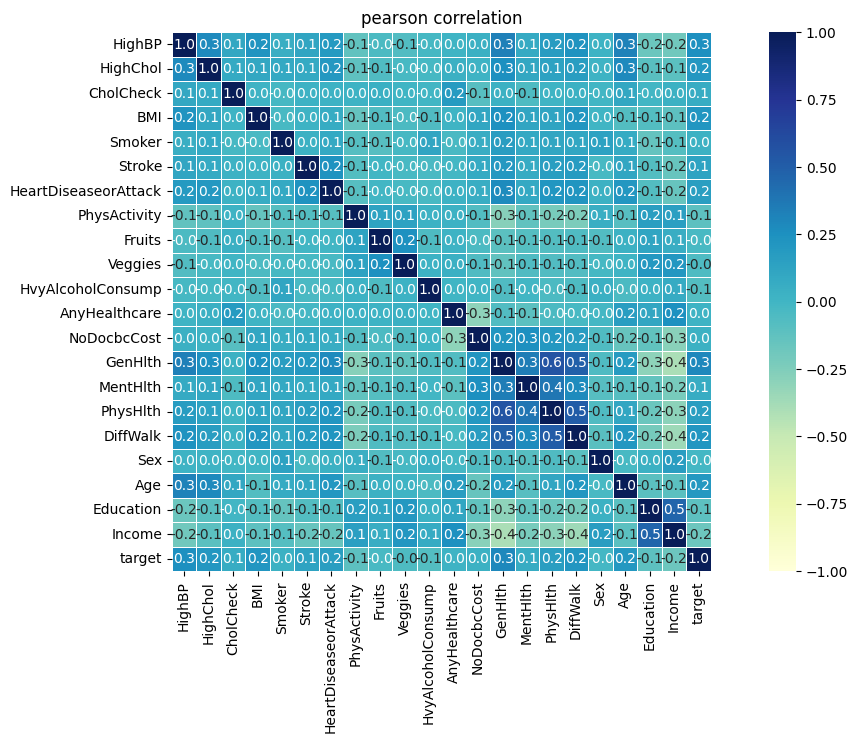

In [ ]:
corr_matrix = df.copy()
plt.figure(figsize=(15,7), dpi=100)

for col in corr_matrix.columns:
  if corr_matrix[col].dtype == "O":
          corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson",numeric_only = True)
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.1f', cmap="YlGnBu", cbar=True, linewidths=0.5, square=True)
plt.title("pearson correlation")

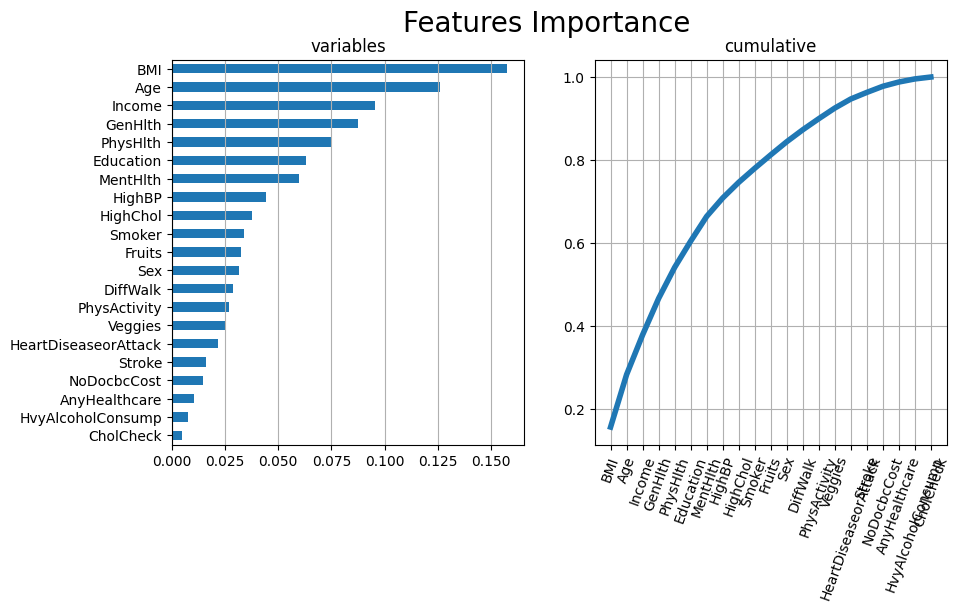

In [ ]:
'''
Оцениваем важность каждой фичи c помощью RandomForestClassifier
'''
X = train_x_scaled.values
y = train_y_scaled.values
feature_names = train_x_scaled.columns.tolist()
model = ensemble.RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, "VARIABLE":feature_names}).sort_values("IMPORTANCE", ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(10,5), dpi=100)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both') # Настроим линии сетки.

plt.show()

In [ ]:
'''
Проектирование, обучение, тестирование и оценка модели машинного обучения:
'''
X_train = train_x_scaled
y_train = train_y_scaled

X_test = test_x_scaled
y_test = test_y_scaled

In [ ]:
'''
Будем использовать GradientBoostingClassifier - градиентный бустинг. Он строит предсказание в виде ансамбля слабых предсказывающих моделей, которыми в основном являются деревья решений. Из нескольких слабых моделей в итоге мы собираем одну, но уже эффективную. Общая идея алгоритма – последовательное применение предиктора (предсказателя) таким образом, что каждая последующая модель сводит ошибку предыдущей к минимуму.
 Оценивать качество предсказаний будем по RandomizedSearchCV
'''

model = ensemble.GradientBoostingClassifier()
param_dic = {'learning_rate':[0.15,0.1,0.05],       # весовой коэффициент для поправок по новым деревьям при добавлении в модель
             'n_estimators':[100,250,500],          # количество деревьев, добавленных в модель
             'max_depth':[2,3,4,5],                 # максимальная глубина дерева
             'min_samples_split':[2,4,6],           # задает минимальное количество выборок для разделения
             'min_samples_leaf':[1,3,5],            # минимальное количество выборок для формирования листа
             'max_features':[2,3,4],                # квадратный корень из функций обычно является хорошей отправной точкой
             'subsample':[0.7,0.8,0.9,1]}           # образцы, которые будут использоваться для подгонки индивидуального базового файла
random_search = model_selection.RandomizedSearchCV(model,
                                                   param_distributions=param_dic, n_iter=10,
                                                   scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

Best Model parameters: {'subsample': 0.7, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': 2, 'learning_rate': 0.05}
Best Model mean accuracy: 0.8220000000000001


In [ ]:
model.fit(X_train, y_train)
predicted_prob = model.predict_proba(X_test)
predicted = model.predict(X_test).astype('int32')

In [ ]:
predicted_prob

array([[0.86356405, 0.13643595],
       [0.99026588, 0.00973412],
       [0.80063617, 0.19936383],
       ...,
       [0.34666282, 0.65333718],
       [0.86498246, 0.13501754],
       [0.65682794, 0.34317206]])

In [ ]:
y_test.astype('int32')

,target
2944,0
2069,0
3716,0
1368,0
4923,0
...,...
3719,0
4737,0
3819,1
854,0


In [ ]:
predicted_prob

array([[0.86356405, 0.13643595],
       [0.99026588, 0.00973412],
       [0.80063617, 0.19936383],
       ...,
       [0.34666282, 0.65333718],
       [0.86498246, 0.13501754],
       [0.65682794, 0.34317206]])

In [ ]:
## Accuray e AUC
'''
Теперь смотрим метрики.
НА ТЕСТОВОМ ДАТАСЕТЕ
'''
accuracy = metrics.accuracy_score(y_test, predicted) # оценим точность классификации.

auc = metrics.roc_auc_score(y_test, predicted_prob[:, 1], multi_class='ovo', average="weighted") # возвращаем долю правильно классифицированных выборок.
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))

recall = metrics.recall_score(y_test, predicted, average="weighted")
precision = metrics.precision_score(y_test, predicted, average="weighted")
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.82
Auc: 0.78
Recall (all 1s predicted right): 0.82
Precision (confidence when predicting a 1): 0.79
Detail:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1214
           1       0.54      0.26      0.35       286

    accuracy                           0.82      1500
   macro avg       0.69      0.60      0.62      1500
weighted avg       0.79      0.82      0.79      1500



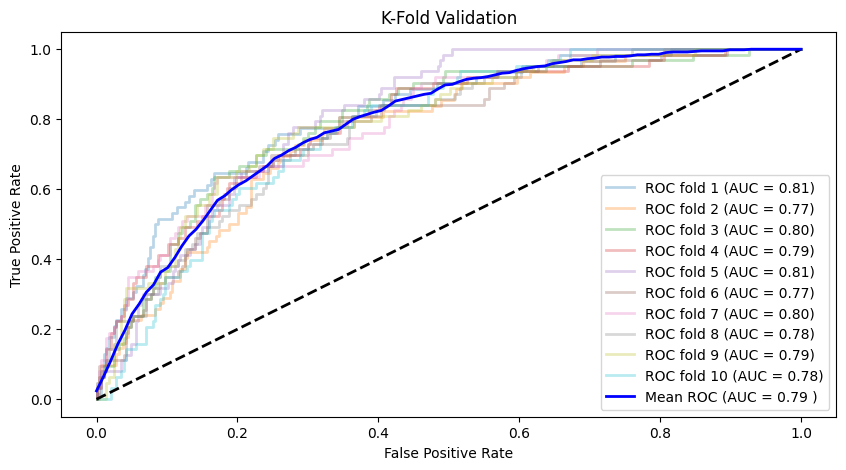

In [ ]:
'''
Строим ROC кривые
'''
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure(figsize=(10,5),dpi=100)
i = 1
for train, test in cv.split(X_train, y_train):
    X_train_selected = X_train.iloc[train]

    y_train_selected = y_train.iloc[train]
    X_train_selected_test = X_train.iloc[test]
    y_train_selected_test = y_train.iloc[test]

    prediction = model.fit(X_train_selected, y_train_selected).predict_proba(X_train_selected_test)
    fpr, tpr, t = metrics.roc_curve(y_train_selected_test, prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1

plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")

plt.show()

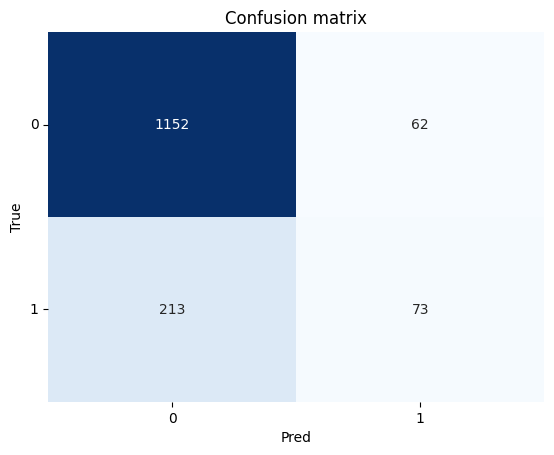

In [ ]:
'''
Confusion matrix (Мультиклассовый)
'''

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)

plt.show()

In [ ]:
'''
Вспомогательная функция для построения confusion matrix для каждого класса
'''
def compute_class(ls_res, class_value): # возвращаем строку имен классов
    y_t_class = ls_res.copy().astype(int)
    y_t_class = y_t_class.apply(lambda c: 1 if c  == class_value  else 0)
    return  y_t_class

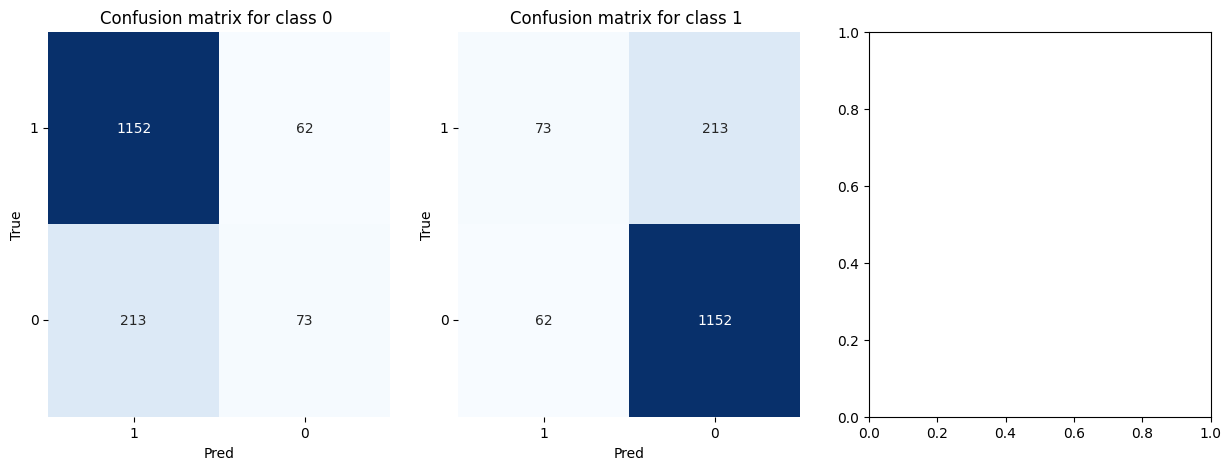

In [ ]:
'''
Confusion matrix (для каждого класса по отдельности)
'''

classes = np.unique(y_test).astype(int)
lbs = [1,0]

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5),dpi=100)

for class_i in classes:
    y_one_class = compute_class(y_test,class_i)
    predicted_one_class = compute_class(pd.Series(predicted.tolist()),class_i)#возвращает строку имен классов
    cm = metrics.confusion_matrix(y_one_class, predicted_one_class, labels=lbs)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax[class_i])
    ax[class_i].set(xlabel="Pred", ylabel="True", title=f"Confusion matrix for class {class_i} ")
    ax[class_i].set_xticklabels(labels=lbs, rotation=0)
    ax[class_i].set_yticklabels(labels=lbs, rotation=0)

'''
построим график

'''
plt.show()

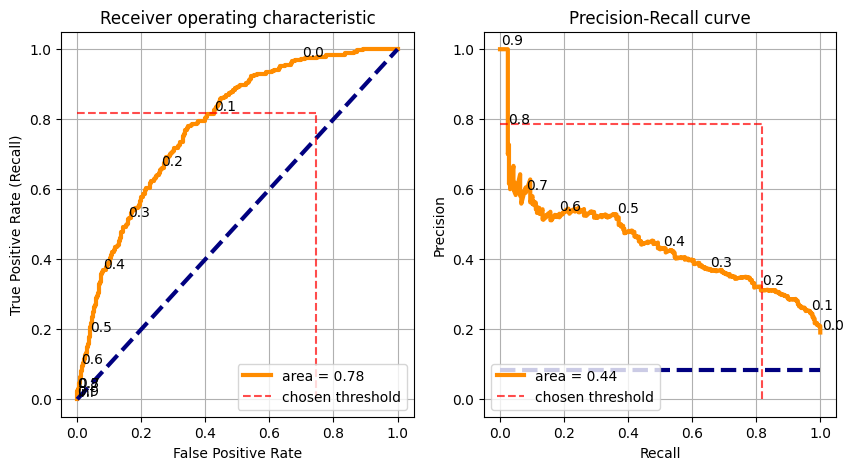

In [ ]:
'''
Еще ROC кривые
'''

classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5), dpi=100)

fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next

precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob[:,1], pos_label=1)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)

thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]),
                    xytext=(recalls[i],precisions[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
plt.show()

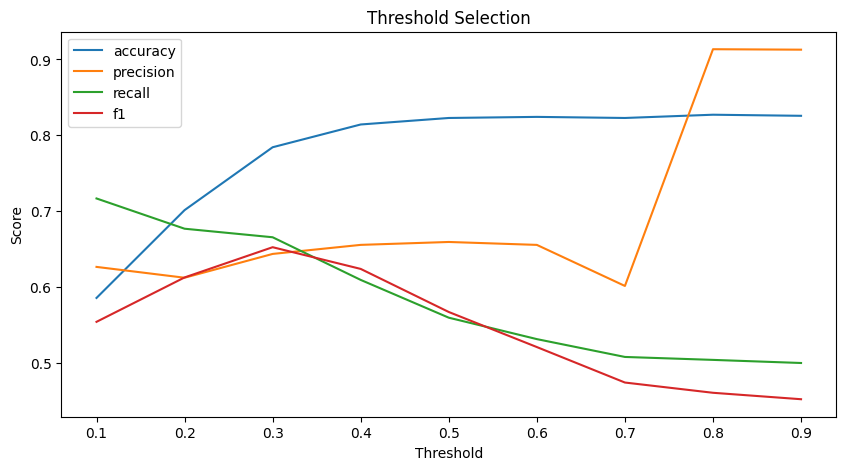

In [ ]:
## calculate scores for different thresholds
'''
Определим, какие значения отсечки лучше всего для нашей модели.
Для этого построим график ("значение отсечки", "значение метрики") для каждой метрики accuracy, precision, recall, f1
'''
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted, average='macro'))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted, average='macro'))

df_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Threshold Selection")
df_scores.plot(ax=ax)

plt.show()